In [19]:
import pandas as pd
import numpy as np
import ast

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [51]:
df = pd.read_csv("hasil removaltiga.csv", usecols=["filtering","sentimen"])
df.columns = ["sentimen", "tweet"]
df.head(10)

,sentimen,tweet
0,netral,"['kesehatan', 'vaksin', 'terkini', 'viralkan',..."
1,negatif,"['i', 'faham', 'org', 'tua', 'pergi', 'vaksin'..."
2,negatif,"['tengoklah', 'doktor', 'cerita', 'pasal', 'ke..."
3,netral,"['side', 'effects', 'vaksin', 'memutihkan', 'k..."
4,positif,"['kisah', 'positif', 'covid', 'bumi', 'england..."
5,negatif,"['pakar', 'perubatan', 'famili', 'klinik', 'ke..."
6,negatif,"['lately', 'banyaklah', 'dengar', 'orang', 'ca..."
7,negatif,"['frontliner', 'pfizer', 'vaksin', 'second', '..."
8,negatif,"['berat', 'sek', 'menate', 'mano', 'duk', 'has..."
9,positif,"['negara', 'pengeluar', 'vaksin', 'negara', 'p..."


In [52]:
#convert string to list
def convert(tweets):
    tweets = ast.literal_eval(tweets)
    return [tweet for tweet in tweets]

df["list_tweet"] = df["tweet"].apply(convert)
print(df["list_tweet"])

print("\ntype : ", type(df["list_tweet"]))

0      [kesehatan, vaksin, terkini, viralkan, cerita,...
1      [i, faham, org, tua, pergi, vaksin, kesehatan,...
2      [tengoklah, doktor, cerita, pasal, keburukan, ...
3             [side, effects, vaksin, memutihkan, kulit]
4      [kisah, positif, covid, bumi, england, sherynn...
                             ...                        
297    [tau, pm, bodo, cakap, kali, vaksin, kononkono...
298    [lepas, petugas, suntik, vaksin, amount, vaksi...
299                                     [reject, vaksin]
300    [pharmaniaga, membekalkan, vaksin, sinnovac, c...
301    [tiada, monopoli, kerana, syarikat, membekalka...
Name: list_tweet, Length: 302, dtype: object

type :  <class 'pandas.core.series.Series'>


In [53]:
#tf 
def calc_TF(document):
    # Counts the number of times the word appears in review
    TF_dict = {}
    for term in document:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    # Computes tf for each word
    for term in TF_dict:
        TF_dict[term] = TF_dict[term] / len(document)
    return TF_dict

df["TF_dict"] = df['list_tweet'].apply(calc_TF)
df["TF_dict"].head(10)

0    {'kesehatan': 0.1111111111111111, 'vaksin': 0....
1    {'i': 0.18181818181818182, 'faham': 0.09090909...
2    {'tengoklah': 0.125, 'doktor': 0.125, 'cerita'...
3    {'side': 0.2, 'effects': 0.2, 'vaksin': 0.2, '...
4    {'kisah': 0.09090909090909091, 'positif': 0.18...
5    {'pakar': 0.06666666666666667, 'perubatan': 0....
6    {'lately': 0.06666666666666667, 'banyaklah': 0...
7    {'frontliner': 0.1111111111111111, 'pfizer': 0...
8    {'berat': 0.058823529411764705, 'sek': 0.11764...
9    {'negara': 0.36363636363636365, 'pengeluar': 0...
Name: TF_dict, dtype: object

In [54]:
# Check TF result
#index = 1

#print('%20s' % "term", "\t", "TF\n")
#for key in df["TF_dict"][index]:
 #   print('%20s' % key, "\t", df["TF_dict"][index][key])

In [55]:
#idf
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(df["TF_dict"])

In [56]:
n_document = len(df)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [57]:
#calc TF-IDF
def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    #For each word in the review, we multiply its tf and its idf.
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

#Stores the TF-IDF Series
df["TF-IDF_dict"] = df["TF_dict"].apply(calc_TF_IDF)
#df["TF-IDF_dict"].head()
hasil_tfidf = df["TF-IDF_dict"]
hasil_tfidf.head()

0    {'kesehatan': 0.4182796520355062, 'vaksin': 0....
1    {'i': 0.660179177399097, 'faham': 0.4192558844...
2    {'tengoklah': 0.6271599796018655, 'doktor': 0....
3    {'side': 0.783733509629363, 'effects': 0.86482...
4    {'kisah': 0.45611634880135676, 'positif': 0.91...
Name: TF-IDF_dict, dtype: object

In [58]:
# sort descending by value for DF dictionary 
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)[:10]

# Create a list of unique words from sorted dictionay `sorted_DF`
unique_term = [item[0] for item in sorted_DF]

def calc_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

df["TF_IDF_Vec"] = df["TF-IDF_dict"].apply(calc_TF_IDF_Vec)

print("print first row matrix TF_IDF_Vec Series\n")
print(df["TF_IDF_Vec"][0])

print("\nmatrix size : ", len(df["TF_IDF_Vec"][0]))

print first row matrix TF_IDF_Vec Series

[0.026461815967043875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

matrix size :  10


In [59]:
# Convert Series to List
TF_IDF_Vec_List = np.array(df["TF_IDF_Vec"].to_list())

# Sum element vector in axis=0 
sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))
    
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
2,ambil,9.686418
0,vaksin,9.135818
1,covid,7.670076
3,orang,7.219020
5,suntik,6.886128
6,astrazeneca,5.901321
4,kena,5.634099
7,cakap,4.549349
8,la,4.103375
9,pasal,3.492091


In [18]:
new = df["TF-IDF_dict"].apply(pd.Series)
new_df = new.fillna(0)
new_df

,sehat,vaksin,kini,viralkan,cerita,benar,kongsi,dengan,semua,kalau,...,jakarta,66,inggris,majority,kalang,carpet,kelan,pharmaniaga,sinnovac,china
0,0.313710,0.019497,0.326556,0.418107,0.302582,0.283987,0.418107,0.226225,0.235005,0.201216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.171114,0.010635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.021269,0.000000,0.000000,0.330090,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.029245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.000000,0.022282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
298,0.000000,0.035095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
299,0.000000,0.077988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
300,0.000000,0.023396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501728,0.501728,0.501728


In [11]:
#def convert(TF_IDF_Dict):
#    data = [] 
#    for item in hasil_tfidf:
#        for key, value in hasil_tfidf.items():
#            data = list(zip(value.keys(), value.values()))
#            return data
        
#df["TFIDF"] = df["TF-IDF_dict"].apply(convert)
#df["TFIDF"].head(10)

In [12]:
#dt = df["TF-IDF_dict"]
#dataf = pd.DataFrame(dt)
#convert = dataf.to_string()
#convert

In [13]:
# Cek hasil TF-IDF
#index = 90

#print('%20s' % "term", "\t", '%10s' % "TF", "\t", '%20s' % "TF-IDF\n")
#for key in df["TF-IDF_dict"][index]:
 #   print('%20s' % key, "\t", df["TF_dict"][index][key] ,"\t" , df["TF-IDF_dict"][index][key])

In [11]:
x = new_df
y = df['sentimen']
x

,sehat,vaksin,kini,viralkan,cerita,benar,kongsi,dengan,semua,kalau,...,jakarta,66,inggris,majority,kalang,carpet,kelan,pharmaniaga,sinnovac,china
0,0.313710,0.019497,0.326556,0.418107,0.302582,0.283987,0.418107,0.226225,0.235005,0.201216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.171114,0.010635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.021269,0.000000,0.000000,0.330090,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.029245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.000000,0.022282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
298,0.000000,0.035095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
299,0.000000,0.077988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
300,0.000000,0.023396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501728,0.501728,0.501728


In [22]:
#splitting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)


print("total Training Data :", y_train.shape)
print("total Testing Data :", y_test.shape)

total Training Data : (241,)
total Testing Data : (61,)


In [23]:
y_train.value_counts(ascending=True)

positif    78
negatif    81
netral     82
Name: sentimen, dtype: int64

In [24]:
y_test.value_counts(ascending=True)

netral     19
negatif    20
positif    22
Name: sentimen, dtype: int64

In [25]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
prediksi = nb.predict(x_test)

#nb = MultinomialNB().fit(x_train,y_train)
#prediksi = nb.predict(x_test)

In [27]:
print(classification_report(y_test, prediksi))

              precision    recall  f1-score   support

     negatif       0.62      0.65      0.63        20
      netral       0.52      0.58      0.55        19
     positif       0.58      0.50      0.54        22

    accuracy                           0.57        61
   macro avg       0.57      0.58      0.57        61
weighted avg       0.57      0.57      0.57        61



In [28]:
print (accuracy_score(y_test, prediksi))

0.5737704918032787


In [29]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [31]:
import pickle

In [32]:
filename = 'model_analisis.pkl'
pickle.dump(model, open(filename, 'wb'))

In [33]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.5737704918032787


In [34]:
predict = loaded_model.predict(x_test)
print(predict)

['positif' 'negatif' 'netral' 'positif' 'negatif' 'netral' 'negatif'
 'negatif' 'positif' 'negatif' 'netral' 'negatif' 'negatif' 'negatif'
 'netral' 'negatif' 'negatif' 'netral' 'netral' 'netral' 'positif'
 'positif' 'positif' 'positif' 'netral' 'positif' 'positif' 'netral'
 'positif' 'negatif' 'positif' 'positif' 'negatif' 'netral' 'negatif'
 'negatif' 'netral' 'negatif' 'netral' 'negatif' 'positif' 'negatif'
 'netral' 'netral' 'negatif' 'positif' 'netral' 'negatif' 'netral'
 'negatif' 'negatif' 'negatif' 'netral' 'positif' 'positif' 'negatif'
 'netral' 'positif' 'netral' 'positif' 'netral']


<AxesSubplot:xlabel='sentimen'>

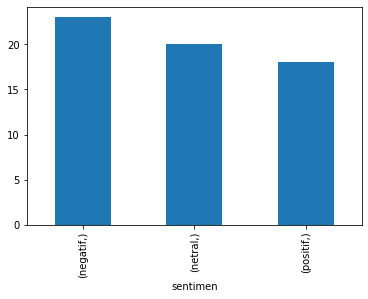

In [35]:
df1 = pd.DataFrame(predict, columns=['sentimen'])
df1.value_counts().plot(kind='bar')